##### Imports

In [25]:
from datetime import datetime,timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.calc import wind_components, reduce_point_density
from metpy.units import units
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover, wx_code_map
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
%run /kt11/ktyle/python/metargem.py # Load in a collection of functions that process GEMPAK weather  data.

In [28]:
# Figure Borders
latN = 46.5
latS = 43.75
lonW = -77.0
lonE = -72.0

# Figure Center
cLat = (latN + latS)/2 # Central Latitude
cLon = (lonW + lonE )/2 # Central Longitude

inital = datetime(2022, 2, 22, 18) # Inital Time Set as November 16th at 00z
Time_Intervals = [0] # Sets up the i value for the loop statement below

#For *all* available global stations, we use the catalog below:
metar_cat_url = 'http://thredds.atmos.albany.edu:8080/thredds/catalog/metarArchive/ncdecoded/catalog.xml?dataset=metarArchive/ncdecoded/Archived_Metar_Station_Data_fc.cdmr'
catalog = TDSCatalog(metar_cat_url) # Referencing metar_cat_url as catalog # When we print this, we only wnat one dataset type within this catalog
metar_dataset = catalog.datasets['Feature Collection']  # Create an object named "metar_dataset" to store this dataset in
ncss_url = metar_dataset.access_urls['NetcdfSubset'] # We only want a single hour for all times so we call for a subset of the overall data
ncss = NCSS(ncss_url) # 

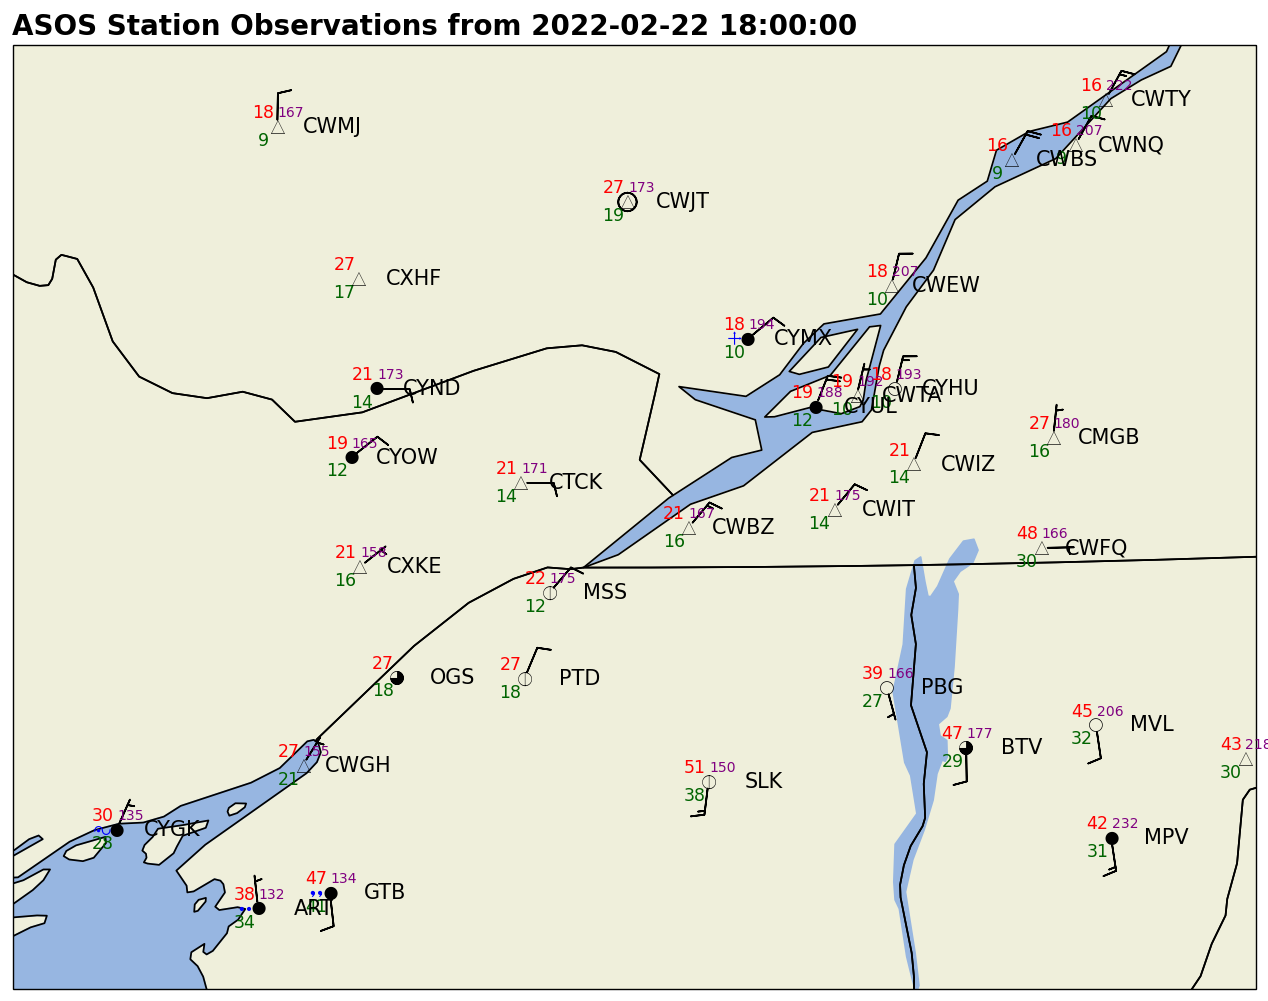

In [29]:
for i in Time_Intervals: 
    
    query = ncss.query() 
    query.lonlat_box(north=latN, south=latS, east=lonE, west=lonW)
    query.time(inital + timedelta(hours = i))
    query.variables('TMPC', 'DWPC', 'PMSL','SKNT', 'DRCT','ALTI','WNUM','VSBY','CHC1', 'CHC2', 'CHC3','CTYH', 'CTYM', 'CTYL' )
    query.accept('csv')
    data = ncss.get_data(query)
    
    current_time_str = str(inital + timedelta(hours = i))
    figure_title = f'ASOS Station Observations from {current_time_str}'
    saved_figure_title = current_time_str

    lats = data['latitude']
    lons = data['longitude']
    tair = (data['TMPC'] * units ('degC')).to('degF')
    dewp = (data['DWPC'] * units ('degC')).to('degF')
    altm = (data['ALTI'] * units('inHg')).to('mbar')
    slp = data['PMSL']
    u, v = wind_components(data['SKNT'] * units.knots, data['DRCT'] * units.degree)
    wnum = (np.nan_to_num(data['WNUM'],True).astype(int))
    convert_wnum (wnum)
    chc1 = (np.nan_to_num(data['CHC1'],True).astype(int))
    chc2 = (np.nan_to_num(data['CHC2'],True).astype(int))
    chc3 = (np.nan_to_num(data['CHC3'],True).astype(int))
    cloud_cover = calc_clouds(chc1, chc2, chc3)
    stid = np.array([s.decode() for s in data['station']])
    
    proj = ccrs.Stereographic(central_longitude=cLon, central_latitude=cLat)
    xy = proj.transform_points(ccrs.PlateCarree(), lons, lats)
    density = 10000
    mask = reduce_point_density(xy, density)
    dpi = 125
    
    fig = plt.figure(figsize=(15,10), dpi=dpi)
    proj = ccrs.Stereographic(central_longitude=cLon, central_latitude=cLat)
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_facecolor(cfeature.COLORS['water'])
   
    land_mask = cfeature.NaturalEarthFeature('physical', 'land', '50m',edgecolor='face',facecolor=cfeature.COLORS['land'])
    ax.add_feature(land_mask)
    
    lake_mask = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',edgecolor='face',facecolor=cfeature.COLORS['water'])
    ax.add_feature(lake_mask)
    
    state_borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
    ax.add_feature(state_borders, linestyle='solid', edgecolor='black')
    
    ax.set_extent ((lonW+0,lonE+0,latS+0,latN+0), crs=ccrs.PlateCarree())
    stationplot = StationPlot(ax, lons[mask], lats[mask], transform=ccrs.PlateCarree(),fontsize=8)
    stationplot.plot_parameter('NW', tair[mask], color='red', fontsize=10)
    stationplot.plot_parameter('SW', dewp[mask], color='darkgreen', fontsize=10)
    stationplot.plot_parameter('NE', slp[mask], color='purple', formatter=lambda v: format(10 * v, '.0f')[-3:])
    stationplot.plot_symbol('C', cloud_cover[mask], sky_cover)
    stationplot.plot_symbol('W', wnum[mask], current_weather,color='blue',fontsize=12)
    stationplot.plot_text((4, 0),stid[mask], color='black',fontsize = 12)
    stationplot.plot_barb(u[mask], v[mask],zorder=2)
    
    ax.set_title(figure_title,fontsize=16,loc = 'left',fontweight = 'bold')
    plt.savefig (saved_figure_title) # Saved Figure Title 